In [1]:
import sys
from pathlib import Path
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import optuna
from optuna.pruners import MedianPruner
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error


In [2]:
PROJECT_ROOT = Path.cwd().parent      
SRC_DIR = PROJECT_ROOT / "src"

sys.path.append(str(SRC_DIR))


from config_paths import PROCESSED_DIR


In [3]:
import pandas as pd

train_df = pd.read_csv(PROCESSED_DIR / "dataset_train_v2.csv", index_col=0)
test_df  = pd.read_csv(PROCESSED_DIR / "dataset_test_v2.csv", index_col=0)

print(train_df.shape, test_df.shape)

(837, 120) (359, 120)


In [53]:
train_df['Frio (Kw)'].describe()

count      836.000000
mean     24694.528708
std       8412.340740
min          0.000000
25%      19375.500000
50%      25580.500000
75%      30740.000000
max      56128.000000
Name: Frio (Kw), dtype: float64

In [ ]:
test_df['Frio (Kw)'].describe()

In [4]:
from preprocessing_pipeline import full_preprocess_pipe

In [5]:
def add_target_next_day(df, source_col="Frio (Kw)", target_col="target_frio"):
    df = df.copy()
    df[target_col] = df[source_col].shift(-1)
    # Eliminamos la última fila que se queda sin target
    df = df.dropna(subset=[target_col])
    return df

train_df = add_target_next_day(train_df, source_col="Frio (Kw)", target_col="target_frio")
test_df  = add_target_next_day(test_df,  source_col="Frio (Kw)", target_col="target_frio")


# TRAIN
X_train = train_df.drop(columns=["target_frio"])
y_train = train_df["target_frio"]

# TEST
X_test = test_df.drop(columns=["target_frio"])
y_test = test_df["target_frio"]


full_preprocess_pipe.fit(X_train, y_train)

X_train_ready = full_preprocess_pipe.transform(X_train)
X_test_ready  = full_preprocess_pipe.transform(X_test)

# Saco los nans que hayan quedado por las features temporales
def drop_na_and_align(X, y):
    mask = ~X.isna().any(axis=1)
    X = X.loc[mask]
    y = y.loc[mask]

    return X, y

X_train_ready, y_train = drop_na_and_align(X_train_ready, y_train)
X_test_ready,  y_test  = drop_na_and_align(X_test_ready,  y_test)

**Random Forest**

Entrenamiento

In [6]:
from sklearn.model_selection import TimeSeriesSplit
def objective(trial):

    # Hiperparámetros
    n_estimators = trial.suggest_int("n_estimators", 100, 600)
    max_depth = trial.suggest_int("max_depth", 5, 40)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )

    tscv = TimeSeriesSplit(n_splits=5)

    maes  = []
    rmses = []
    r2s   = []

    for fold_idx, (train_idx, valid_idx) in enumerate(tscv.split(X_train_ready)):

        X_tr = X_train_ready.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]

        X_va = X_train_ready.iloc[valid_idx]
        y_va = y_train.iloc[valid_idx]

        # Entrenar
        model.fit(X_tr, y_tr)

        # Predecir
        pred = model.predict(X_va)

        # Métricas
        mae  = mean_absolute_error(y_va, pred)
        rmse = root_mean_squared_error(y_va, pred)
        r2   = r2_score(y_va, pred)

        maes.append(mae)
        rmses.append(rmse)
        r2s.append(r2)

        trial.report(mae, step=fold_idx)

        if trial.should_prune():
            raise optuna.TrialPruned()

    # --- registro adicional para visualización (opcional) ---
    trial.set_user_attr("rmse_mean", np.mean(rmses))
    trial.set_user_attr("r2_mean",   np.mean(r2s))

    # Optuna optimiza MAE
    return np.mean(maes)

# Estudio
study = optuna.create_study(
    direction="minimize",
    pruner=MedianPruner(n_warmup_steps=5)
)

study.optimize(objective, n_trials=50)

print("Mejores hiperparámetros:", study.best_params)
print("Mejor MAE (CV):", study.best_value)

print("RMSE medio (CV):", study.best_trial.user_attrs["rmse_mean"])
print("R2 medio (CV):",   study.best_trial.user_attrs["r2_mean"])


[I 2025-11-16 20:42:57,011] A new study created in memory with name: no-name-926d8cc7-5265-4604-98be-3890c2dcc698
[I 2025-11-16 20:42:58,077] Trial 0 finished with value: 4221.064362709838 and parameters: {'n_estimators': 380, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 4221.064362709838.
[I 2025-11-16 20:42:58,590] Trial 1 finished with value: 3873.5030056218266 and parameters: {'n_estimators': 279, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 3873.5030056218266.
[I 2025-11-16 20:42:58,990] Trial 2 finished with value: 5290.720948078745 and parameters: {'n_estimators': 129, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False}. Best is trial 1 with value: 3873.5030056218266.
[I 2025-11-16 20:43:00,015] Trial 3 finished with value: 4219.452803123573 and p

Mejores hiperparámetros: {'n_estimators': 600, 'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}
Mejor MAE (CV): 3847.1270851491527
RMSE medio (CV): 5165.946828633276
R2 medio (CV): 0.40487865795269096


In [14]:
import os
from datetime import datetime

# --- Definir la ruta del archivo de logs ---
# (Asumiendo que PROJECT_ROOT está definido como en tu celda 2)
LOGS_DIR = PROJECT_ROOT / "results"
LOG_FILE = LOGS_DIR / "experiment_logs.csv"

# --- Crear el directorio si no existe ---
os.makedirs(LOGS_DIR, exist_ok=True)

# --- 1. Obtener los resultados del estudio de Optuna ---
trials_df = study.trials_dataframe()

# --- 2. Preparar el DataFrame para el log ---

# Renombrar 'value' por la métrica que optimizamos (MAE)
trials_df = trials_df.rename(columns={"value": "mae_cv"})

# Extraer las métricas de CV que guardamos en 'user_attrs'
trials_df["rmse_cv"] = trials_df["user_attrs_rmse_mean"]
trials_df["r2_cv"] = trials_df["user_attrs_r2_mean"]

# Añadir columnas requeridas por el proyecto
trials_df["model_name"] = "RandomForest"
trials_df["timestamp"] = datetime.now().isoformat()

# --- 3. Filtrar y ordenar columnas ---
# Columnas de hiperparámetros (empiezan con 'params_')
param_cols = [col for col in trials_df.columns if col.startswith("params_")]

# Columnas de métricas y metadata
metric_cols = ["model_name", "timestamp", "mae_cv", "rmse_cv", "r2_cv"]

# DataFrame final
log_df = trials_df[metric_cols + param_cols]

# --- 4. Guardar en el CSV ---
if not os.path.exists(LOG_FILE):
    # Si el archivo no existe, lo creamos con cabecera
    log_df.to_csv(LOG_FILE, index=False)
    print(f"Log creado en: {LOG_FILE}")
else:
    # Si ya existe, añadimos los datos sin la cabecera
    log_df.to_csv(LOG_FILE, mode='a', header=False, index=False)
    print(f"Nuevos experimentos añadidos a: {LOG_FILE}")

# Muestra las primeras filas de lo que se guardó
display(log_df.head())

Log creado en: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/results/experiment_logs.csv


,model_name,timestamp,mae_cv,rmse_cv,r2_cv,params_bootstrap,params_max_depth,params_max_features,params_min_samples_leaf,params_min_samples_split,params_n_estimators
0,RandomForest,2025-11-16T21:21:20.964828,4221.064363,5671.109459,0.248948,True,19,None,9,9,380
1,RandomForest,2025-11-16T21:21:20.964828,3873.503006,5193.829547,0.398047,False,12,sqrt,7,13,279
2,RandomForest,2025-11-16T21:21:20.964828,5290.720948,6738.389338,-0.113472,False,24,None,3,5,129
3,RandomForest,2025-11-16T21:21:20.964828,4219.452803,5653.077616,0.258669,True,40,log2,10,5,409
4,RandomForest,2025-11-16T21:21:20.964828,4938.692232,6498.067866,-0.011133,False,40,None,10,17,312


Métricas

In [ ]:
# --- Importaciones necesarias ---
from dvclive import Live
import joblib

# --- Definir directorios (asumiendo PROJECT_ROOT) ---
MODELS_DIR = PROJECT_ROOT / "models"
os.makedirs(MODELS_DIR, exist_ok=True)

MODEL_VERSION = "v1.0.0" # Versionado semántico 
MODEL_NAME = "random_forest"
MODEL_PATH = MODELS_DIR / f"{MODEL_NAME}_{MODEL_VERSION}.pkl"


# --- Iniciar el tracking con DVCLive ---
# save_dvc_exp=True es para que dvc sepa que esto es una corrida
with Live(save_dvc_exp=True) as live:
    
    # --- 1. Log de Hiperparámetros ---
    # Logueamos los mejores parámetros encontrados por Optuna
    live.log_params(study.best_params)
    live.log_param("model_name", MODEL_NAME)
    live.log_param("model_version", MODEL_VERSION)

    # --- 2. Entrenamiento del Modelo Final ---
    best_rf = RandomForestRegressor(
        **study.best_params,
        random_state=42,
        n_jobs=-1
    )
    
    best_rf.fit(X_train_ready, y_train)

    # --- 3. Evaluación y Log de Métricas ---
    
    # ---------- TRAIN ----------
    pred_train = best_rf.predict(X_train_ready)
    train_mae  = mean_absolute_error(y_train, pred_train)
    train_rmse = root_mean_squared_error(y_train, pred_train)
    train_r2   = r2_score(y_train, pred_train)
    
    # Log de métricas de Train
    live.log_metric("train_mae", round(train_mae, 4))
    live.log_metric("train_rmse", round(train_rmse, 4))
    live.log_metric("train_r2", round(train_r2, 4))

    # ---------- TEST ----------
    pred_test = best_rf.predict(X_test_ready)
    test_mae  = mean_absolute_error(y_test, pred_test)
    test_rmse = root_mean_squared_error(y_test, pred_test)
    test_r2   = r2_score(y_test, pred_test)

    # Log de métricas de Test
    live.log_metric("test_mae", round(test_mae, 4))
    live.log_metric("test_rmse", round(test_rmse, 4))
    live.log_metric("test_r2", round(test_r2, 4))
    
    # Imprimir en consola (como ya hacías)
    print("=== Random Forest ===")
    print(f"Train -> MAE: {train_mae:.4f} | RMSE: {train_rmse:.4f} | R²: {train_r2:.4f}")
    print(f"Test  -> MAE: {test_mae:.4f}  | RMSE: {test_rmse:.4f}  | R²: {test_r2:.4f}")

    # --- 4. Guardar y Versionar el Modelo ---
    joblib.dump(best_rf, MODEL_PATH)
    
    # Loguea el artefacto (el modelo) para que DVC lo rastree
    live.log_artifact(
        str(MODEL_PATH),
        type="model",
        name=MODEL_NAME # Un ID simple y limpio
    )

=== Random Forest ===
Train -> MAE: 2159.5572 | RMSE: 3264.7775 | R²: 0.8493
Test  -> MAE: 2963.5048  | RMSE: 4029.2202  | R²: 0.5665


	results/experiment_logs.csv, notebooks/models.ipynb


**LightGBM**

Entrenamiento

In [8]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

def objective_lgbm(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "random_state": 42,
        "n_jobs": -1,
        "objective": "regression",
        "verbosity": -1  # apaga los warnings molestos
    }

    maes, rmses, r2s = [], [], []

    for fold_idx, (train_idx, valid_idx) in enumerate(tscv.split(X_train_ready)):

        X_tr = X_train_ready.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]

        X_va = X_train_ready.iloc[valid_idx]
        y_va = y_train.iloc[valid_idx]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_tr, y_tr)

        pred = model.predict(X_va)

        # Métricas
        mae  = mean_absolute_error(y_va, pred)
        rmse = root_mean_squared_error(y_va, pred)
        r2   = r2_score(y_va, pred)

        maes.append(mae)
        rmses.append(rmse)
        r2s.append(r2)

        trial.report(mae, step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # guardar métricas secundarias dentro del trial
    trial.set_user_attr("rmse_mean", float(np.mean(rmses)))
    trial.set_user_attr("r2_mean",   float(np.mean(r2s)))

    # optimizamos solo por MAE
    return float(np.mean(maes))


# -------- Ejecutar estudio --------
study_lgbm = optuna.create_study(
    direction="minimize",
    pruner=MedianPruner(n_warmup_steps=3)
)

study_lgbm.optimize(objective_lgbm, n_trials=50)

# -------- Resultados --------
print("LGBM - Mejores hiperparámetros:", study_lgbm.best_params)
print("LGBM - Mejor MAE (CV):", study_lgbm.best_value)
print("LGBM - RMSE (CV):",     study_lgbm.best_trial.user_attrs["rmse_mean"])
print("LGBM - R² (CV):",       study_lgbm.best_trial.user_attrs["r2_mean"])

[I 2025-11-16 20:43:41,520] A new study created in memory with name: no-name-fa2d7c2c-a3b8-49c6-b6fb-b53c46098f0d
[I 2025-11-16 20:43:44,925] Trial 0 finished with value: 5594.207282669311 and parameters: {'n_estimators': 430, 'learning_rate': 0.07851961298087269, 'num_leaves': 190, 'max_depth': 19, 'min_child_samples': 31, 'subsample': 0.9803698175079533, 'colsample_bytree': 0.6925876882083243}. Best is trial 0 with value: 5594.207282669311.
[I 2025-11-16 20:43:45,851] Trial 1 finished with value: 4586.400546920019 and parameters: {'n_estimators': 234, 'learning_rate': 0.02048641524696238, 'num_leaves': 121, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.5817771445519219, 'colsample_bytree': 0.5515508389121166}. Best is trial 1 with value: 4586.400546920019.
[I 2025-11-16 20:43:52,890] Trial 2 finished with value: 5358.898814011549 and parameters: {'n_estimators': 413, 'learning_rate': 0.019949262307233817, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 8, 'subsample

LGBM - Mejores hiperparámetros: {'n_estimators': 281, 'learning_rate': 0.010427868897409966, 'num_leaves': 59, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.5343972445366038, 'colsample_bytree': 0.5262327300252863}
LGBM - Mejor MAE (CV): 4428.915025416985
LGBM - RMSE (CV): 5869.601676879849
LGBM - R² (CV): 0.1831859790924371


In [16]:
# --- 1. Obtener los resultados del estudio LGBM ---
trials_df_lgbm = study_lgbm.trials_dataframe()

# --- 2. Preparar el DataFrame para el log ---
trials_df_lgbm = trials_df_lgbm.rename(columns={"value": "mae_cv"})

# Extraer métricas de CV
trials_df_lgbm["rmse_cv"] = trials_df_lgbm["user_attrs_rmse_mean"]
trials_df_lgbm["r2_cv"] = trials_df_lgbm["user_attrs_r2_mean"]

# Añadir columnas requeridas
trials_df_lgbm["model_name"] = "LightGBM" # <-- Único cambio
trials_df_lgbm["timestamp"] = datetime.now().isoformat()

# --- 3. Filtrar y ordenar columnas ---
param_cols_lgbm = [col for col in trials_df_lgbm.columns if col.startswith("params_")]
metric_cols_lgbm = ["model_name", "timestamp", "mae_cv", "rmse_cv", "r2_cv"]

log_df_lgbm = trials_df_lgbm[metric_cols_lgbm + param_cols_lgbm]

# --- 4. Añadir al CSV (sin cabecera, modo 'append') ---
log_df_lgbm.to_csv(LOG_FILE, mode='a', header=False, index=False)
print(f"Nuevos experimentos de LightGBM añadidos a: {LOG_FILE}")

# Muestra las primeras filas de lo que se guardó
display(log_df_lgbm.head())

Nuevos experimentos de LightGBM añadidos a: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/results/experiment_logs.csv


,model_name,timestamp,mae_cv,rmse_cv,r2_cv,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_n_estimators,params_num_leaves,params_subsample
0,LightGBM,2025-11-16T21:25:40.683609,5594.207283,7127.621168,-0.360497,0.692588,0.078520,19,31,430,190,0.980370
1,LightGBM,2025-11-16T21:25:40.683609,4586.400547,6071.896011,0.098590,0.551551,0.020486,3,18,234,121,0.581777
2,LightGBM,2025-11-16T21:25:40.683609,5358.898814,6989.160856,-0.272169,0.731167,0.019949,12,8,413,31,0.544518
3,LightGBM,2025-11-16T21:25:40.683609,5463.203607,6980.256867,-0.270068,0.653961,0.083793,14,28,552,44,0.623047
4,LightGBM,2025-11-16T21:25:40.683609,5166.254166,6701.236551,-0.138968,0.602160,0.036525,18,20,462,25,0.885854


Métricas

In [17]:
# --- Definir directorios y versión ---
MODEL_VERSION = "v1.0.0"
MODEL_NAME = "lightgbm" # <-- Cambio aquí
MODEL_PATH = MODELS_DIR / f"{MODEL_NAME}_{MODEL_VERSION}.pkl"


# --- Iniciar el tracking con DVCLive ---
with Live(save_dvc_exp=True) as live:
    
    # --- 1. Log de Hiperparámetros ---
    live.log_params(study_lgbm.best_params)
    live.log_param("model_name", MODEL_NAME)
    live.log_param("model_version", MODEL_VERSION)

    # --- 2. Entrenamiento del Modelo Final ---
    best_lgbm = lgb.LGBMRegressor(
        **study_lgbm.best_params,
        random_state=42,
        n_jobs=-1,
        objective="regression",
        verbosity=-1
    )
    
    best_lgbm.fit(X_train_ready, y_train)

    # --- 3. Evaluación y Log de Métricas ---
    
    # ---------- TRAIN ----------
    pred_train = best_lgbm.predict(X_train_ready)
    train_mae  = mean_absolute_error(y_train, pred_train)
    train_rmse = root_mean_squared_error(y_train, pred_train)
    train_r2   = r2_score(y_train, pred_train)
    
    live.log_metric("train_mae", round(train_mae, 4))
    live.log_metric("train_rmse", round(train_rmse, 4))
    live.log_metric("train_r2", round(train_r2, 4))

    # ---------- TEST ----------
    pred_test = best_lgbm.predict(X_test_ready)
    test_mae  = mean_absolute_error(y_test, pred_test)
    test_rmse = root_mean_squared_error(y_test, pred_test)
    test_r2   = r2_score(y_test, pred_test)

    live.log_metric("test_mae", round(test_mae, 4))
    live.log_metric("test_rmse", round(test_rmse, 4))
    live.log_metric("test_r2", round(test_r2, 4))
    
    print("=== LGBM Final === ")
    print(f"Train -> MAE: {train_mae:.4f} | RMSE: {train_rmse:.4f} | R²: {train_r2:.4f}")
    print(f"Test  -> MAE: {test_mae:.4f}  | RMSE: {test_rmse:.4f}  | R²: {test_r2:.4f}")

    # --- 4. Guardar y Versionar el Modelo ---
    joblib.dump(best_lgbm, MODEL_PATH)
    
    # Loguea el artefacto (Recuerda el 'name' simple)
    live.log_artifact(
        str(MODEL_PATH),
        type="model",
        name=MODEL_NAME 
    )

=== LGBM Final === 
Train -> MAE: 2655.4943 | RMSE: 3850.8986 | R²: 0.7903
Test  -> MAE: 2994.4695  | RMSE: 4098.6206  | R²: 0.5514


	models/random_forest_v1.0.0.pkl.dvc, results/experiment_logs.csv, notebooks/models.ipynb


**XgBoost**

Entrenamiento

In [10]:
from xgboost import XGBRegressor

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1e-1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "random_state": 42,
        "n_jobs": -1,
        "tree_method": "hist"
    }

    maes, rmses, r2s = [], [], []

    for fold_idx, (train_idx, valid_idx) in enumerate(tscv.split(X_train_ready)):
        X_tr = X_train_ready.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]

        X_va = X_train_ready.iloc[valid_idx]
        y_va = y_train.iloc[valid_idx]

        model = XGBRegressor(**params)
        model.fit(X_tr, y_tr)

        pred = model.predict(X_va)

        mae  = mean_absolute_error(y_va, pred)
        rmse = root_mean_squared_error(y_va, pred)
        r2   = r2_score(y_va, pred)

        maes.append(mae)
        rmses.append(rmse)
        r2s.append(r2)

        trial.report(mae, step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # guardamos métricas adicionales en el trial
    trial.set_user_attr("rmse_mean", float(np.mean(rmses)))
    trial.set_user_attr("r2_mean",   float(np.mean(r2s)))

    # Optuna optimiza solo por MAE
    return float(np.mean(maes))


study_xgb = optuna.create_study(
    direction="minimize",
    pruner=MedianPruner(n_warmup_steps=3)
)
study_xgb.optimize(objective_xgb, n_trials=50)

print("XGB - Mejores hiperparámetros:", study_xgb.best_params)
print("XGB - Mejor MAE (CV):", study_xgb.best_value)
print("XGB - RMSE medio (CV):", study_xgb.best_trial.user_attrs["rmse_mean"])
print("XGB - R² medio (CV):",   study_xgb.best_trial.user_attrs["r2_mean"])


[I 2025-11-16 20:45:49,406] A new study created in memory with name: no-name-6b731f27-e93d-4d07-bc30-9a44b38ea3ef
[I 2025-11-16 20:45:56,378] Trial 0 finished with value: 6114.172274670498 and parameters: {'n_estimators': 588, 'learning_rate': 0.024560500544698858, 'max_depth': 8, 'min_child_weight': 2.539273765468395, 'subsample': 0.7853705240373778, 'colsample_bytree': 0.933342872785569, 'gamma': 3.6146190903992266, 'reg_alpha': 2.2056278966532714e-08, 'reg_lambda': 2.0295451186132785}. Best is trial 0 with value: 6114.172274670498.
[I 2025-11-16 20:46:07,168] Trial 1 finished with value: 5074.378291507419 and parameters: {'n_estimators': 614, 'learning_rate': 0.01816325126620814, 'max_depth': 18, 'min_child_weight': 6.672718284214737, 'subsample': 0.8464183877552072, 'colsample_bytree': 0.605425065730411, 'gamma': 2.329273367676019, 'reg_alpha': 0.07264926826450942, 'reg_lambda': 9.524493141912359}. Best is trial 1 with value: 5074.378291507419.
[I 2025-11-16 20:46:11,627] Trial 2 f

XGB - Mejores hiperparámetros: {'n_estimators': 296, 'learning_rate': 0.010755846481642411, 'max_depth': 17, 'min_child_weight': 3.917305690366425, 'subsample': 0.5008068817135853, 'colsample_bytree': 0.6739605278013356, 'gamma': 2.904544941378167, 'reg_alpha': 0.00048395630630861753, 'reg_lambda': 0.4345094390317974}
XGB - Mejor MAE (CV): 4424.844765906025
XGB - RMSE medio (CV): 5835.7999869974565
XGB - R² medio (CV): 0.18499428679120605


In [18]:
# --- 1. Obtener los resultados del estudio XGB ---
trials_df_xgb = study_xgb.trials_dataframe()

# --- 2. Preparar el DataFrame para el log ---
trials_df_xgb = trials_df_xgb.rename(columns={"value": "mae_cv"})

# Extraer métricas de CV
trials_df_xgb["rmse_cv"] = trials_df_xgb["user_attrs_rmse_mean"]
trials_df_xgb["r2_cv"] = trials_df_xgb["user_attrs_r2_mean"]

# Añadir columnas requeridas
trials_df_xgb["model_name"] = "XGBoost" # <-- Único cambio
trials_df_xgb["timestamp"] = datetime.now().isoformat()

# --- 3. Filtrar y ordenar columnas ---
param_cols_xgb = [col for col in trials_df_xgb.columns if col.startswith("params_")]
metric_cols_xgb = ["model_name", "timestamp", "mae_cv", "rmse_cv", "r2_cv"]

log_df_xgb = trials_df_xgb[metric_cols_xgb + param_cols_xgb]

# --- 4. Añadir al CSV (sin cabecera, modo 'append') ---
log_df_xgb.to_csv(LOG_FILE, mode='a', header=False, index=False)
print(f"Nuevos experimentos de XGBoost añadidos a: {LOG_FILE}")

# Muestra las primeras filas de lo que se guardó
display(log_df_xgb.head())

Nuevos experimentos de XGBoost añadidos a: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/results/experiment_logs.csv


,model_name,timestamp,mae_cv,rmse_cv,r2_cv,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample
0,XGBoost,2025-11-16T21:26:21.646685,6114.172275,8054.552300,-0.887964,0.933343,3.614619,0.024561,8,2.539274,588,2.205628e-08,2.029545,0.785371
1,XGBoost,2025-11-16T21:26:21.646685,5074.378292,6621.337407,-0.130769,0.605425,2.329273,0.018163,18,6.672718,614,7.264927e-02,9.524493,0.846418
2,XGBoost,2025-11-16T21:26:21.646685,5853.564467,7586.411480,-0.564659,0.724761,1.200218,0.090668,4,7.465476,709,3.665695e-03,0.209085,0.834329
3,XGBoost,2025-11-16T21:26:21.646685,5161.659003,6907.584694,-0.267188,0.827359,4.047491,0.022039,20,1.996442,658,4.179539e-08,0.004496,0.736397
4,XGBoost,2025-11-16T21:26:21.646685,5724.653077,7558.113367,-0.590506,0.851873,1.480159,0.036015,18,4.245212,674,1.087289e-04,0.005946,0.775141


Métricas

In [19]:
# --- Definir directorios y versión ---
MODEL_VERSION = "v1.0.0"
MODEL_NAME = "xgboost" # <-- Cambio aquí
MODEL_PATH = MODELS_DIR / f"{MODEL_NAME}_{MODEL_VERSION}.pkl"


# --- Iniciar el tracking con DVCLive ---
with Live(save_dvc_exp=True) as live:
    
    # --- 1. Log de Hiperparámetros ---
    live.log_params(study_xgb.best_params)
    live.log_param("model_name", MODEL_NAME)
    live.log_param("model_version", MODEL_VERSION)

    # --- 2. Entrenamiento del Modelo Final ---
    best_xgb = XGBRegressor(
        **study_xgb.best_params,
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )
    
    best_xgb.fit(X_train_ready, y_train)

    # --- 3. Evaluación y Log de Métricas ---
    
    # ---------- TRAIN ----------
    pred_train_xgb = best_xgb.predict(X_train_ready)
    train_mae_xgb  = mean_absolute_error(y_train, pred_train_xgb)
    train_rmse_xgb = root_mean_squared_error(y_train, pred_train_xgb)
    train_r2_xgb   = r2_score(y_train, pred_train_xgb)
    
    live.log_metric("train_mae", round(train_mae_xgb, 4))
    live.log_metric("train_rmse", round(train_rmse_xgb, 4))
    live.log_metric("train_r2", round(train_r2_xgb, 4))

    # ---------- TEST ----------
    pred_test_xgb = best_xgb.predict(X_test_ready)
    test_mae_xgb  = mean_absolute_error(y_test, pred_test_xgb)
    test_rmse_xgb = root_mean_squared_error(y_test, pred_test_xgb)
    test_r2_xgb   = r2_score(y_test, pred_test_xgb)

    live.log_metric("test_mae", round(test_mae_xgb, 4))
    live.log_metric("test_rmse", round(test_rmse_xgb, 4))
    live.log_metric("test_r2", round(test_r2_xgb, 4))
    
    print("=== XGBoost Final === ")
    print(f"Train -> MAE: {train_mae_xgb:.4f} | RMSE: {train_rmse_xgb:.4f} | R²: {train_r2_xgb:.4f}")
    print(f"Test  -> MAE: {test_mae_xgb:.4f}  | RMSE: {test_rmse_xgb:.4f}  | R²: {test_r2_xgb:.4f}")

    # --- 4. Guardar y Versionar el Modelo ---
    joblib.dump(best_xgb, MODEL_PATH)
    
    # Loguea el artefacto (Recuerda el 'name' simple)
    live.log_artifact(
        str(MODEL_PATH),
        type="model",
        name=MODEL_NAME 
    )

=== XGBoost Final === 
Train -> MAE: 1477.4043 | RMSE: 2415.0779 | R²: 0.9175
Test  -> MAE: 3025.8591  | RMSE: 4042.7737  | R²: 0.5636


	models/lightgbm_v1.0.0.pkl.dvc, models/random_forest_v1.0.0.pkl.dvc, results/experiment_logs.csv, notebooks/models.ipynb


**Ridge**

Entrenamiento

In [12]:
from sklearn.linear_model import Ridge

def objective_ridge(trial):
    # Hiperparámetro a tunear
    params = {
        "alpha": trial.suggest_float("alpha", 1e-3, 1e3, log=True),
        # Podrías sumar más:
        # "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        # "solver": trial.suggest_categorical("solver", ["auto", "svd", "cholesky", "lsqr", "sag", "saga"])
    }

    maes, rmses, r2s = [], [], []

    for fold_idx, (train_idx, valid_idx) in enumerate(tscv.split(X_train_ready)):
        X_tr = X_train_ready.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]

        X_va = X_train_ready.iloc[valid_idx]
        y_va = y_train.iloc[valid_idx]

        model = Ridge(**params)
        model.fit(X_tr, y_tr)

        pred = model.predict(X_va)

        mae  = mean_absolute_error(y_va, pred)
        rmse = root_mean_squared_error(y_va, pred)
        r2   = r2_score(y_va, pred)

        maes.append(mae)
        rmses.append(rmse)
        r2s.append(r2)

        trial.report(mae, step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # guardar métricas adicionales en el trial
    trial.set_user_attr("rmse_mean", float(np.mean(rmses)))
    trial.set_user_attr("r2_mean",   float(np.mean(r2s)))

    # Optuna sigue optimizando solo MAE
    return float(np.mean(maes))


# Estudio Optuna para Ridge
study_ridge = optuna.create_study(
    direction="minimize",
    pruner=MedianPruner(n_warmup_steps=3)
)
study_ridge.optimize(objective_ridge, n_trials=50)

print("Ridge - Mejores hiperparámetros:", study_ridge.best_params)
print("Ridge - Mejor MAE (CV):", study_ridge.best_value)
print("Ridge - RMSE medio (CV):", study_ridge.best_trial.user_attrs["rmse_mean"])
print("Ridge - R² medio (CV):",   study_ridge.best_trial.user_attrs["r2_mean"])

[I 2025-11-16 20:50:24,011] A new study created in memory with name: no-name-3f3d2239-67fc-4151-b4ec-f7ac99a0eae0
[I 2025-11-16 20:50:24,032] Trial 0 finished with value: 4090.1127456723284 and parameters: {'alpha': 1.0850444042034844}. Best is trial 0 with value: 4090.1127456723284.
[I 2025-11-16 20:50:24,044] Trial 1 finished with value: 4340.938525470916 and parameters: {'alpha': 200.9649419797059}. Best is trial 0 with value: 4090.1127456723284.
[I 2025-11-16 20:50:24,052] Trial 2 finished with value: 4038.3770337951028 and parameters: {'alpha': 5.583567079966037}. Best is trial 2 with value: 4038.3770337951028.
[I 2025-11-16 20:50:24,060] Trial 3 finished with value: 4109.847795806278 and parameters: {'alpha': 0.010186582118336307}. Best is trial 2 with value: 4038.3770337951028.
[I 2025-11-16 20:50:24,068] Trial 4 finished with value: 4029.6374892083318 and parameters: {'alpha': 7.616538614054318}. Best is trial 4 with value: 4029.6374892083318.
[I 2025-11-16 20:50:24,075] Trial 

Ridge - Mejores hiperparámetros: {'alpha': 7.616538614054318}
Ridge - Mejor MAE (CV): 4029.6374892083318
Ridge - RMSE medio (CV): 5386.844311060227
Ridge - R² medio (CV): 0.344193201312486


In [20]:
# --- 1. Obtener los resultados del estudio Ridge ---
trials_df_ridge = study_ridge.trials_dataframe()

# --- 2. Preparar el DataFrame para el log ---
trials_df_ridge = trials_df_ridge.rename(columns={"value": "mae_cv"})

# Extraer métricas de CV
trials_df_ridge["rmse_cv"] = trials_df_ridge["user_attrs_rmse_mean"]
trials_df_ridge["r2_cv"] = trials_df_ridge["user_attrs_r2_mean"]

# Añadir columnas requeridas
trials_df_ridge["model_name"] = "Ridge" # <-- Único cambio
trials_df_ridge["timestamp"] = datetime.now().isoformat()

# --- 3. Filtrar y ordenar columnas ---
param_cols_ridge = [col for col in trials_df_ridge.columns if col.startswith("params_")]
metric_cols_ridge = ["model_name", "timestamp", "mae_cv", "rmse_cv", "r2_cv"]

log_df_ridge = trials_df_ridge[metric_cols_ridge + param_cols_ridge]

# --- 4. Añadir al CSV (sin cabecera, modo 'append') ---
log_df_ridge.to_csv(LOG_FILE, mode='a', header=False, index=False)
print(f"Nuevos experimentos de Ridge añadidos a: {LOG_FILE}")

# Muestra las primeras filas de lo que se guardó
display(log_df_ridge.head())

Nuevos experimentos de Ridge añadidos a: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/results/experiment_logs.csv


,model_name,timestamp,mae_cv,rmse_cv,r2_cv,params_alpha
0,Ridge,2025-11-16T21:27:07.740599,4090.112746,5514.710306,0.298558,1.085044
1,Ridge,2025-11-16T21:27:07.740599,4340.938525,5699.353123,0.256603,200.964942
2,Ridge,2025-11-16T21:27:07.740599,4038.377034,5406.547215,0.337207,5.583567
3,Ridge,2025-11-16T21:27:07.740599,4109.847796,5558.286663,0.281854,0.010187
4,Ridge,2025-11-16T21:27:07.740599,4029.637489,5386.844311,0.344193,7.616539


Métricas

In [21]:
# --- Definir directorios y versión ---
MODEL_VERSION = "v1.0.0"
MODEL_NAME = "ridge" # <-- Cambio aquí
MODEL_PATH = MODELS_DIR / f"{MODEL_NAME}_{MODEL_VERSION}.pkl"


# --- Iniciar el tracking con DVCLive ---
with Live(save_dvc_exp=True) as live:
    
    # --- 1. Log de Hiperparámetros ---
    live.log_params(study_ridge.best_params)
    live.log_param("model_name", MODEL_NAME)
    live.log_param("model_version", MODEL_VERSION)

    # --- 2. Entrenamiento del Modelo Final ---
    best_ridge = Ridge(
        **study_ridge.best_params
    )
    
    best_ridge.fit(X_train_ready, y_train)

    # --- 3. Evaluación y Log de Métricas ---
    
    # ---------- TRAIN ----------
    pred_train_ridge = best_ridge.predict(X_train_ready)
    train_mae_ridge  = mean_absolute_error(y_train, pred_train_ridge)
    train_rmse_ridge = root_mean_squared_error(y_train, pred_train_ridge)
    train_r2_ridge   = r2_score(y_train, pred_train_ridge)
    
    live.log_metric("train_mae", round(train_mae_ridge, 4))
    live.log_metric("train_rmse", round(train_rmse_ridge, 4))
    live.log_metric("train_r2", round(train_r2_ridge, 4))

    # ---------- TEST ----------
    pred_test_ridge = best_ridge.predict(X_test_ready)
    test_mae_ridge  = mean_absolute_error(y_test, pred_test_ridge)
    test_rmse_ridge = root_mean_squared_error(y_test, pred_test_ridge)
    test_r2_ridge   = r2_score(y_test, pred_test_ridge)

    live.log_metric("test_mae", round(test_mae_ridge, 4))
    live.log_metric("test_rmse", round(test_rmse_ridge, 4))
    live.log_metric("test_r2", round(test_r2_ridge, 4))
    
    print("=== Ridge Final === ")
    print(f"Train -> MAE: {train_mae_ridge:.4f} | RMSE: {train_rmse_ridge:.4f} | R²: {train_r2_ridge:.4f}")
    print(f"Test  -> MAE: {test_mae_ridge:.4f}  | RMSE: {test_rmse_ridge:.4f}  | R²: {test_r2_ridge:.4f}")

    # --- 4. Guardar y Versionar el Modelo ---
    joblib.dump(best_ridge, MODEL_PATH)
    
    # Loguea el artefacto (Recuerda el 'name' simple)
    live.log_artifact(
        str(MODEL_PATH),
        type="model",
        name=MODEL_NAME 
    )

=== Ridge Final === 
Train -> MAE: 3263.9268 | RMSE: 4567.7745 | R²: 0.7049
Test  -> MAE: 2895.5544  | RMSE: 4047.3908  | R²: 0.5626


	models/xgboost_v1.0.0.pkl.dvc, models/lightgbm_v1.0.0.pkl.dvc, models/random_forest_v1.0.0.pkl.dvc, results/experiment_logs.csv, notebooks/models.ipynb


Usamos dvc para encontrar el mejor modelo. Concretamente, corremos el comando  **dvc exp show**

| Experiment | Created | train_mae | train_rmse | train_r2 | test_mae | test_rmse | test_r2 | alpha | model |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| workspace | - | 3263.9 | 4567.8 | 0.7049 | 2895.6 | 4047.4 | 0.5626 | 7.6165 | ridge |
| feature/modeling | 09:31 PM | 3263.9 | 4567.8 | 0.7049 | 2895.6 | 4047.4 | 0.5626 | 7.6165 | ridge |

**Predichos vs reales**

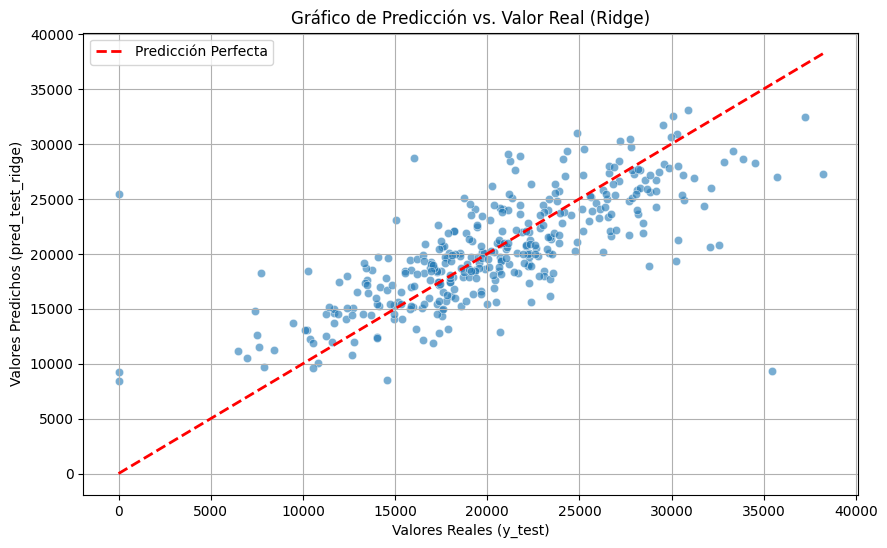

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Usamos las variables 'y_test' y 'pred_test_ridge' que ya existen
plt.figure(figsize=(10, 6))

# Scatter plot de valores reales vs. predichos
sns.scatterplot(x=y_test, y=pred_test_ridge, alpha=0.6)

# Línea de 45 grados (predicción perfecta)
max_val = max(y_test.max(), pred_test_ridge.max())
min_val = min(y_test.min(), pred_test_ridge.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')

plt.xlabel("Valores Reales (y_test)")
plt.ylabel("Valores Predichos (pred_test_ridge)")
plt.title("Gráfico de Predicción vs. Valor Real (Ridge)")
plt.legend()
plt.grid(True)
plt.show()

**Residuos**

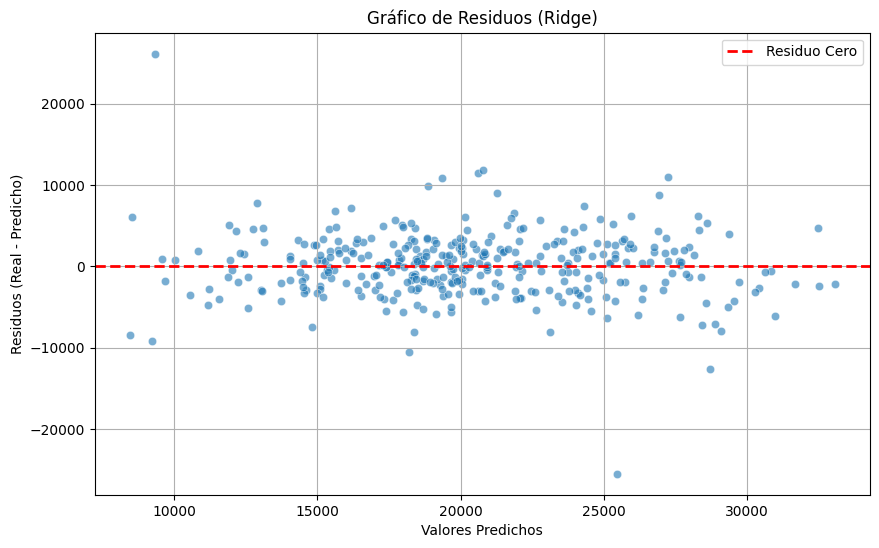

In [23]:
# Calcular los residuos
residuos_ridge = y_test - pred_test_ridge

plt.figure(figsize=(10, 6))

# Scatter plot de valores predichos vs. residuos
sns.scatterplot(x=pred_test_ridge, y=residuos_ridge, alpha=0.6)

# Línea horizontal en cero (ideal)
plt.axhline(y=0, color='r', linestyle='--', lw=2, label='Residuo Cero')

plt.xlabel("Valores Predichos")
plt.ylabel("Residuos (Real - Predicho)")
plt.title("Gráfico de Residuos (Ridge)")
plt.legend()
plt.grid(True)
plt.show()

=== Features más importantes (Coeficientes de Ridge) ===


,feature,coefficient,abs_coefficient
0,Frio (Kw),3093.266473,3093.266473
2,Frio (Kw)_ma_14,3017.247411,3017.247411
5,Servicios (Kw),1656.466170,1656.466170
4,Frio (Kw)_ma_7,807.293508,807.293508
6,KW Obrador Contratistas,-762.349845,762.349845
1,Frio (Kw)_ma_3,-697.294995,697.294995
7,Frio (Kw)_lag_2,-545.033703,545.033703
8,Tot A130/330/430,246.992083,246.992083
9,KW Servicio L2,153.837455,153.837455
3,Sala Maq (Kw),104.533011,104.533011


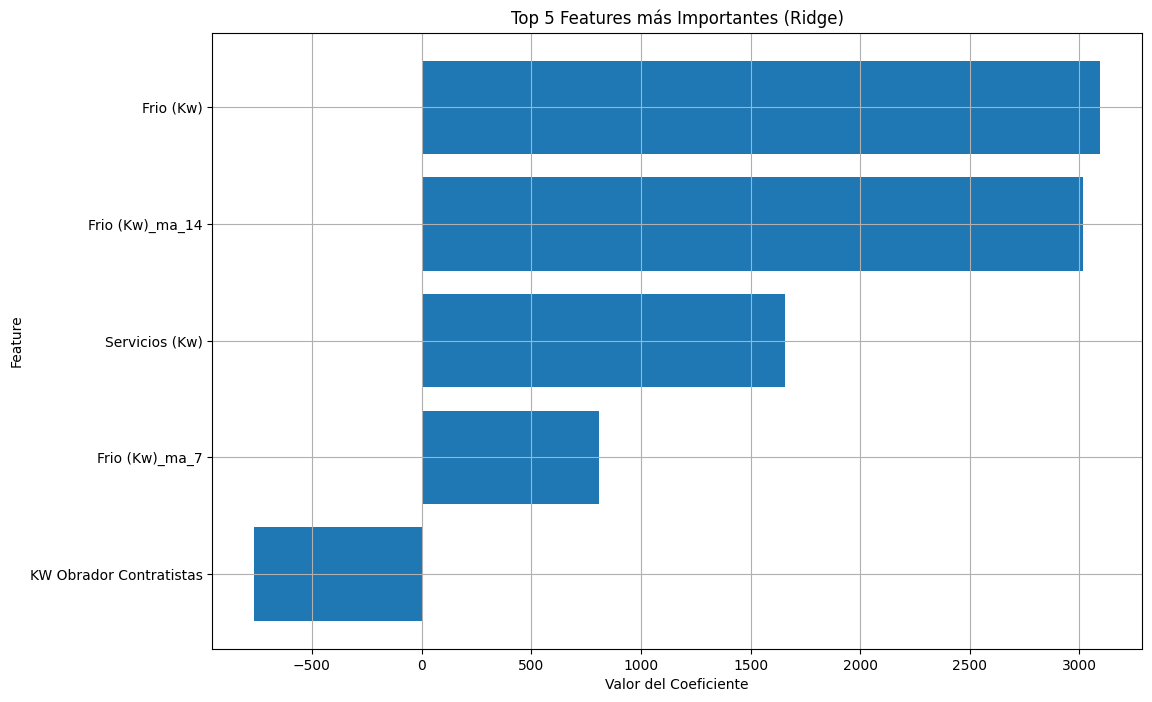

In [27]:
# 1. Obtener los coeficientes del modelo Ridge
coefficients = best_ridge.coef_

# 2. Obtener los nombres de las features (¡directo de tu DataFrame!)
# X_train_ready es el DataFrame final con el que entrenaste el modelo
feature_names = X_train_ready.columns

# 3. Crear un DataFrame para analizar
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# 4. Ordenar por importancia (valor absoluto)
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)

print("=== Features más importantes (Coeficientes de Ridge) ===")
display(coef_df.head(15))

# 5. Visualizar las Top 5 features
plt.figure(figsize=(12, 8))
top_5 = coef_df.head(5).sort_values(by='abs_coefficient', ascending=True)

plt.barh(top_5['feature'], top_5['coefficient'])
plt.xlabel("Valor del Coeficiente")
plt.ylabel("Feature")
plt.title("Top 5 Features más Importantes (Ridge)")
plt.grid(True)
plt.show()

**Modelo Final y Registro de Modelos** (entrenamos con train+test)

In [ ]:
print(study_ridge.best_params)

In [ ]:
# --- Definir el nombre del modelo final (producción) ---
FINAL_MODEL_VERSION = "v1.0.0"
FINAL_MODEL_NAME = "ridge_final" # Nuevo nombre para no sobrescribir
FINAL_MODEL_PATH = MODELS_DIR / f"{FINAL_MODEL_NAME}_{FINAL_MODEL_VERSION}.pkl"

print(f"--- Fase 3.4: Re-entrenamiento Final del Modelo Ganador ({FINAL_MODEL_NAME}) ---")

# 1. Combinar todos los datos disponibles
print("Combinando datos de train y test para el re-entrenamiento...")
X_full = pd.concat([X_train_ready, X_test_ready])
y_full = pd.concat([y_train, y_test])
print(f"Total de datos para re-entrenamiento: {X_full.shape}")

# 2. Inicializar el modelo final con los mejores hiperparámetros
final_production_model = Ridge(
    **study_ridge.best_params
)

# 3. Re-entrenar el modelo con TODOS los datos
print(f"Re-entrenando el modelo final con {len(y_full)} muestras...")
final_production_model.fit(X_full, y_full)

# 4. Guardar el modelo final de producción en su nuevo archivo
joblib.dump(final_production_model, FINAL_MODEL_PATH)

print("\nRe-entrenamiento completado")
print(f"El modelo validado está en: {MODEL_PATH}")
print(f"El modelo final (re-entrenado) está en: {FINAL_MODEL_PATH}")

--- Fase 3.4: Re-entrenamiento Final del Modelo Ganador (ridge) ---
Combinando datos de train y test para el re-entrenamiento...
Total de datos para re-entrenamiento: (1190, 10)
Re-entrenando ridge con 1190 muestras...

Re-entrenamiento completado
El archivo del modelo final ha sido guardado en: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/models/ridge_v1.0.0.pkl
